In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

sklearn.set_config(display=”diagram”)

<font size=6>
    Sberbank Russian Housing Market: target distribution cleaning and modeling
</font>

**TODOs**

4. More EDA
    * Identify quantities to be removed:
        * $\checkmark$ ~~IDs which contribute to the spikes in the neg. tail of the 'price_doc' distribution~~ $\to$ _this led to a big step in improvement_
            * ~~or see if they're correlated with another feature, like 'sub_area'~~ $\to$ did not find this; just removed sampled IDs
            * **open** 
                * is it possible to automatically detect narrow-bin spikes in a distribution? and eleminate the rows which contribute to them?
        * $\checkmark$ ~~check the distribution of the 'sub_area' feature~~
            * ~~are there enough samples for each category?~~ 

<hr style="border: solid rgb(0,0,0) 0.0px; background-color: rgb(0,0,0);height: 2.0px;"/>

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [4]:
import os

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import random
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 20)]
random.shuffle(colors)

In [6]:
#import importlib
import sys
sys.path.append('./helpers/')

## Load the data

In [120]:
df = pd.read_csv('../../datasets/sberbank-russian-housing-market/train.csv', \
                 infer_datetime_format=True, parse_dates=['timestamp'])

In [121]:
df.shape

(30471, 292)

Get the dtypes of the DF; save to a dict for later use

In [122]:
df_dtypes = df.dtypes.reset_index().rename(columns={'index':'column', 0:'datatype'})
df_dtype_dict = dict(zip(df_dtypes.column, df_dtypes.datatype.astype(str)))

## Preprocess the data

### Feature work: the target

#### Separate the target feature

**Note** the target feature may also need to be transformed, _e.g._ rescaled

In [123]:
target_feature = 'price_doc'
target_col = [target_feature]

In [124]:
df[target_col].head()

,price_doc
0,5850000
1,6000000
2,5700000
3,13100000
4,16331452


In [125]:
df_targ = df[['id']+target_col].copy()

In [126]:
df = df.drop(columns=target_feature)

In [127]:
#feature_importance_dropped_cols = ['incineration_raion', 'big_market_raion', 'sub_area']
#df = df.drop(columns=feature_importance_dropped_cols)

#### Inspect and clean the target

In [128]:
df_targ['price_doc'].describe()

count    3.047100e+04
mean     7.123035e+06
std      4.780111e+06
min      1.000000e+05
25%      4.740002e+06
50%      6.274411e+06
75%      8.300000e+06
max      1.111111e+08
Name: price_doc, dtype: float64

In [129]:
targ_vals = df_targ['price_doc'].values

In [130]:
bin_width = 1e5
bins=np.arange(bin_width, 1.2e8 + bin_width, bin_width)
print(len(bins))

1200


In [131]:
hist_df_price_doc, _ = np.histogram(targ_vals, bins=bins, density=False)

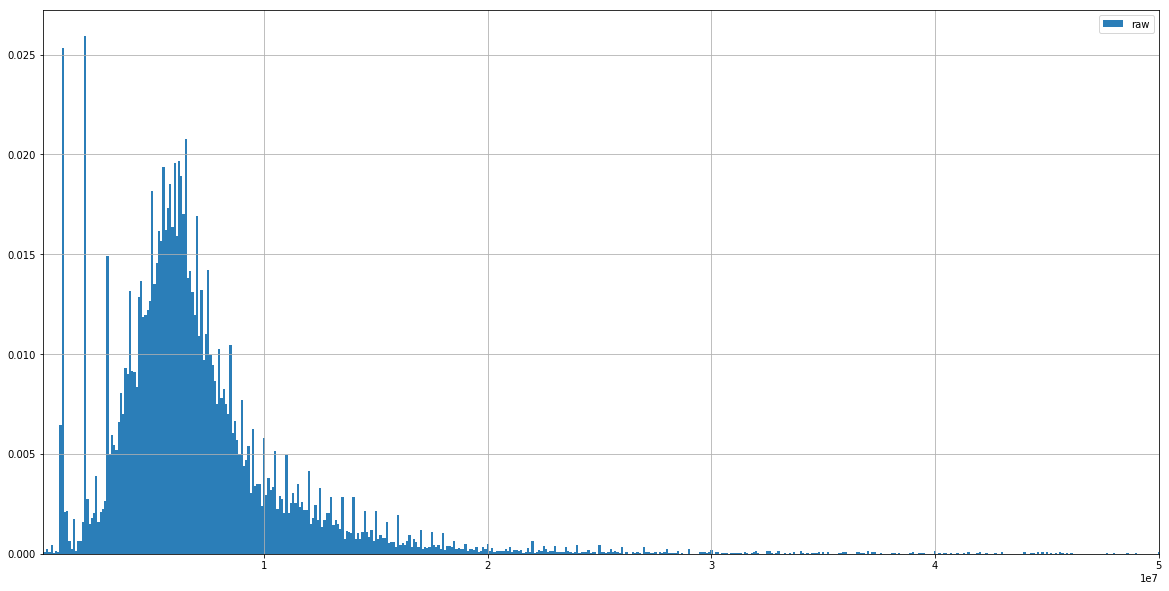

In [132]:
fig, ax = plt.subplots(1,1,figsize=[20,10])
#ax.bar( x=bins[:-1],height=hist_test, width=bin_width, label='test', alpha=0.5)
ax.bar( x=bins[:-1],height=hist_df_price_doc/30471.0, width=bin_width, label='raw', alpha=0.95)
ax.set_xlim(1e5, 5e7)
ax.legend()
ax.grid();

In [144]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

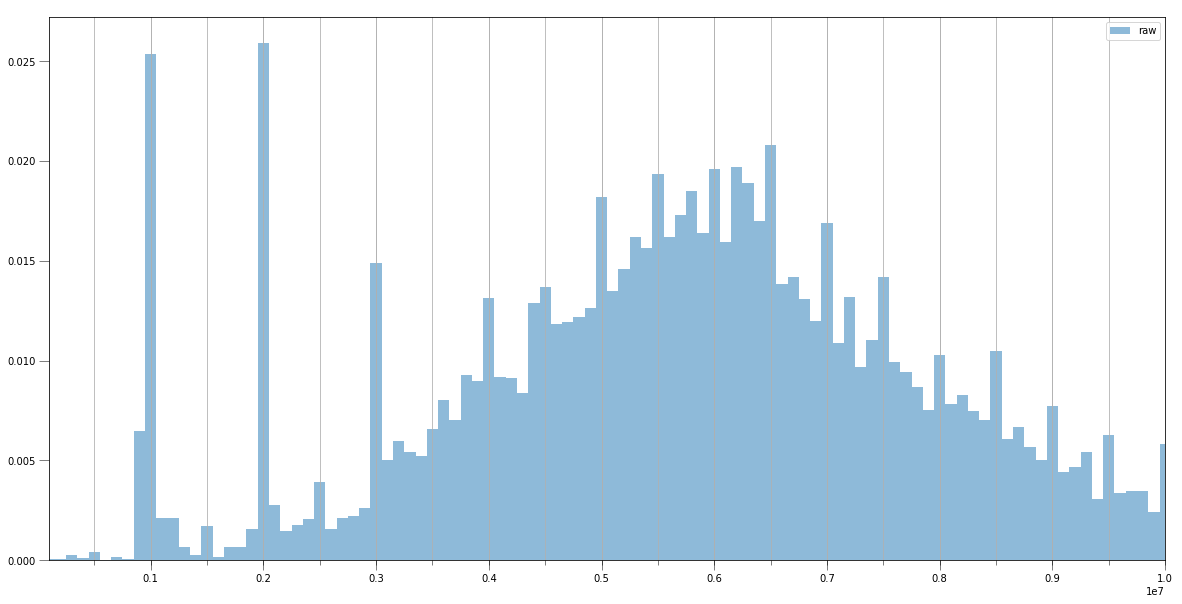

In [171]:
fig, ax = plt.subplots(1,1,figsize=[20,10])
#ax.bar( x=bins[:-1],height=hist_test, width=bin_width, label='test', alpha=0.5)
ax.bar( x=bins[:-1],height=hist_df_price_doc/30471.0, width=bin_width, label='raw', alpha=0.5)
#ax.plot(bins[:-1],hist_df_price_doc/30471.0, '.:')
ax.set_xlim(1e5, 1e7)

ax.legend()

#ax.set_xticks(np.arange(0,1e7,1e6), minor=True)
# Make a plot with major ticks that are multiples of 20 and minor ticks that
# are multiples of 5.  Label major ticks with '%d' formatting but don't label
# minor ticks.
ax.xaxis.set_major_locator(MultipleLocator(1e6))
#ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(5e5))

ax.tick_params(which='both', width=0.5)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=5)

ax.grid(which='both',axis='x');

**Notes** there are spikes in price values for every interval of 500k CURRENCY; some are reasonable, but mostly they appear distinct. 
Such spikes could be due to some mechanism which (due to their lack of counts) would not be picked up in a model.

In [173]:
price_peaks = np.arange(1,20.5,0.5)

1. bin the prices

In [223]:
df_targ['price_doc_bin'] = df_targ['price_doc'].apply(lambda x: x-x%bin_width)

In [226]:
df_targ[df_targ['price_doc'] == 1e6].count()

id               747
price_doc        747
price_doc_bin    747
dtype: int64

In [230]:
df_targ[df_targ['price_doc_bin'] == 0.9e6].count()

id               197
price_doc        197
price_doc_bin    197
dtype: int64

In [244]:
hist_df_price_doc[8:40]

array([197, 772,  64,  65,  20,   8,  53,   5,  20,  20,  48, 790,  84,
        45,  54,  63, 119,  48,  64,  68,  80, 454, 153, 182, 166, 159,
       201, 245, 214, 283, 274, 401])

In [250]:
avg_counts = []
for z in price_peaks:
    
    #lo_ = df_targ[(df_targ['price_doc']<(z*1e6)) & (df_targ['price_doc']>=(z*1e6-1e4))]['price_doc'].count()
    #hi_ = df_targ[(df_targ['price_doc']>(z*1e6)) & (df_targ['price_doc']<=(z*1e6+5e4))]['price_doc'].count()    
    
    lo = df_targ[(df_targ['price_doc_bin']==(z*1e6)-1e5)]['price_doc'].count()
    sp = df_targ[(df_targ['price_doc_bin']==(z*1e6))]['price_doc'].count()
    hi = df_targ[(df_targ['price_doc_bin']==(z*1e6)+1e5)]['price_doc'].count()  
    
    avg = 0.5*(lo+hi)

    print(z,'\t',lo,'\t', sp,'\t', hi, '\t', avg)    
    #print(z,'\t',lo_,lo, avg, hi,hi_)
    
    avg_counts.append(avg)

1.0 	 197 	 772 	 64 	 130.5
1.5 	 8 	 53 	 5 	 6.5
2.0 	 48 	 790 	 84 	 66.0
2.5 	 63 	 119 	 48 	 55.5
3.0 	 80 	 454 	 153 	 116.5
3.5 	 159 	 201 	 245 	 202.0
4.0 	 274 	 401 	 279 	 276.5
4.5 	 392 	 417 	 361 	 376.5
5.0 	 385 	 554 	 411 	 398.0
5.5 	 477 	 590 	 494 	 485.5
6.0 	 499 	 597 	 485 	 492.0
6.5 	 518 	 633 	 421 	 469.5
7.0 	 365 	 515 	 332 	 348.5
7.5 	 336 	 433 	 303 	 319.5
8.0 	 229 	 313 	 238 	 233.5
8.5 	 214 	 319 	 185 	 199.5
9.0 	 153 	 235 	 134 	 143.5
9.5 	 93 	 191 	 103 	 98.0
10.0 	 73 	 177 	 90 	 81.5
10.5 	 102 	 157 	 68 	 85.0
11.0 	 62 	 150 	 63 	 62.5
11.5 	 77 	 106 	 71 	 74.0
12.0 	 67 	 126 	 45 	 56.0
12.5 	 51 	 101 	 41 	 46.0
13.0 	 62 	 87 	 44 	 53.0
13.5 	 38 	 87 	 23 	 30.5
14.0 	 31 	 86 	 23 	 27.0
14.5 	 34 	 65 	 34 	 34.0
15.0 	 20 	 65 	 23 	 21.5
15.5 	 24 	 49 	 17 	 20.5
16.0 	 11 	 59 	 13 	 12.0
16.5 	 19 	 29 	 11 	 15.0
17.0 	 11 	 36 	 8 	 9.5
17.5 	 11 	 33 	 13 	 12.0
18.0 	 7 	 31 	 6 	 6.5
18.5 	 11 	 19 	

In [251]:
df_targ_cp = df_targ.copy()

In [252]:
df_targ.count()

id               30471
price_doc        30471
price_doc_bin    30471
dtype: int64

In [257]:
print(df_targ_cp.shape)
for n,z in enumerate(price_peaks):
    
    samp_size = int(avg_counts[n])
    #print(int(samp_size))
    
    df_samp = df_targ_cp[df_targ_cp['price_doc_bin']==(z*1e6)]
    #print('1',df_targ_cp.shape)
    #print('1',df_samp.shape)   
    # There might not be enough rows to properly sample from
    alt_samp_size = df_samp.shape[0]
    df_samp = df_samp.sample(min(samp_size, alt_samp_size))
    #print('1',df_samp.shape)    
    
    df_targ_cp.where(df_targ_cp['price_doc_bin']!=(z*1e6), inplace=True)
    df_targ_cp.dropna(inplace=True)
    #print('2',df_targ_cp.shape)
    
    df_targ_cp = pd.concat([df_targ_cp,df_samp])
    #print('3',df_targ_cp.shape)
    
    #print()

print(df_targ_cp.shape)

(28218, 3)
(26457, 3)


In [258]:
hist_df_price_doc_, _ = np.histogram(df_targ_cp.price_doc.values, bins=bins, density=False)

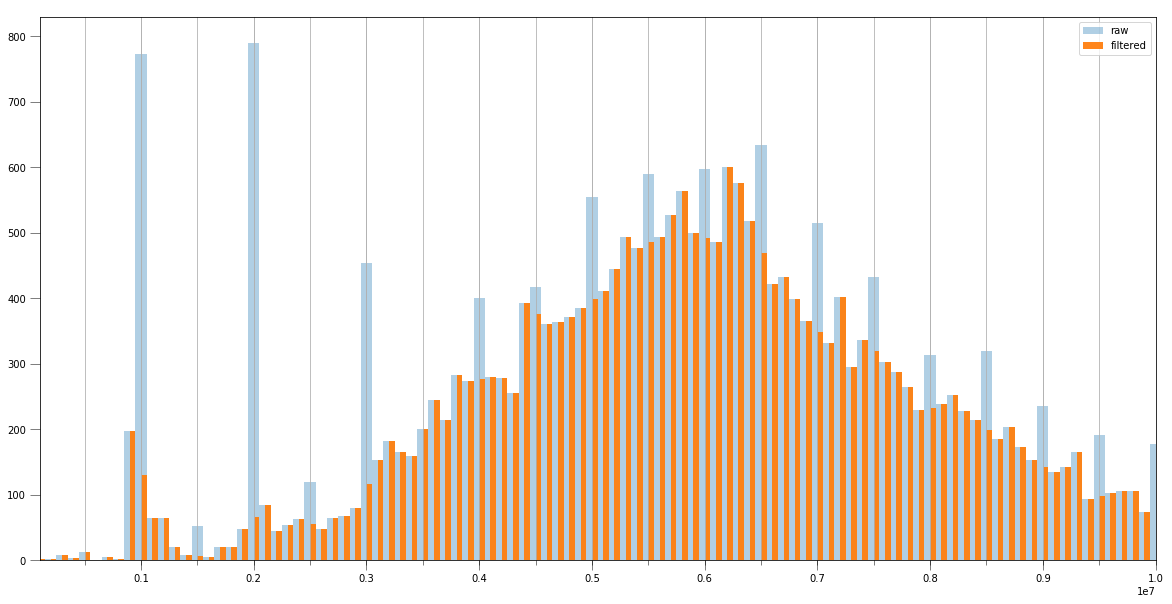

In [262]:
fig, ax = plt.subplots(1,1,figsize=[20,10])
#ax.bar( x=bins[:-1],height=hist_test, width=bin_width, label='test', alpha=0.5)
norma = 1.0 #30471.0

ax.bar( x=bins[:-1],height=hist_df_price_doc /norma, width=bin_width, label='raw', alpha=0.35)
ax.bar( x=bins[:-1],height=hist_df_price_doc_/norma, width=bin_width/2, align='edge', label='filtered', alpha=0.95)

#ax.plot(bins[:-1],hist_df_price_doc/norma, '.:', label='raw', alpha=0.95)
#ax.plot(bins[:-1],hist_df_price_doc_/norma, '+--', label='filtered', alpha=0.95)

ax.set_xlim(1e5, 1e7)

ax.legend()

#ax.set_xticks(np.arange(0,1e7,1e6), minor=True)
# Make a plot with major ticks that are multiples of 20 and minor ticks that
# are multiples of 5.  Label major ticks with '%d' formatting but don't label
# minor ticks.
ax.xaxis.set_major_locator(MultipleLocator(1e6))
#ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(5e5))

ax.tick_params(which='both', width=0.5)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=5)

ax.grid(which='both',axis='x');

In [263]:
peaks = np.arange(1,20.5,0.5)*1e6 

In [270]:
def get_peak_ids(df, identifier, target, peaks, bin_width, verbose=False):
    
    df_cp = df.copy()
    
    target_bin = target + "_bin"
    
    df_cp[target_bin] = df_cp[target].apply(lambda x: x-x%bin_width)
    
    avg_counts = []
    for z in peaks:

        lo = df_targ[(df_targ[target_bin]==z-bin_width)][target].count()
        sp = df_targ[(df_targ[target_bin]==z)][target].count()
        hi = df_targ[(df_targ[target_bin]==z+bin_width)][target].count()  

        avg = 0.5*(lo+hi)

        if verbose: print(z,'\t',lo,'\t', sp,'\t', hi, '\t', avg)    

        avg_counts.append(avg)

    if verbose: print('Starting with:', df_cp.shape)
    for n,z in enumerate(peaks):

        samp_size = int(avg_counts[n])
        if verbose: print(int(samp_size))

        df_samp = df_cp[df_cp[target_bin]==z]
        if verbose: print('1',df_cp.shape)
        if verbose: print('1',df_samp.shape)   
            
        # There might not be enough rows to properly sample from
        alt_samp_size = df_samp.shape[0]
        df_samp = df_samp.sample(min(samp_size, alt_samp_size))
        if verbose: print('1',df_samp.shape)    

        df_cp.where(df_cp[target_bin]!=z, inplace=True)
        df_cp.dropna(inplace=True)
        if verbose: print('2',df_cp.shape)

        df_cp = pd.concat([df_cp, df_samp])
        if verbose: print('3',df_cp.shape)

        if verbose: print()

    if verbose: print('Ending with:', df_cp.shape)    

    id_list = df_cp.dropna()[identifier].tolist()
    
    return id_list

In [267]:
id_listt = df_targ_cp.dropna()['id'].tolist()

In [272]:
id_list = get_peak_ids(df_targ_cp, 'id', 'price_doc', peaks, bin_width)

In [276]:
len(id_listt),len(id_list), df.shape[0], abs(len(id_list)-df.shape[0])/df.shape[0], 

(26457, 26457, 30471, 0.1317318105739884)

### Feature work: the rest

#### Separate some features based on type and/or use

##### Identify the numerical features

In [277]:
ignore_cols = ['id','timestamp']

In [16]:
float_cols = df.drop(columns=ignore_cols).select_dtypes('float').columns.tolist()

int_cols = df.drop(columns=ignore_cols).select_dtypes('int').columns.tolist()

num_cols = df.drop(columns=ignore_cols).select_dtypes(['int', 'float']).columns.tolist()

Select the categorical features

In [17]:
string_cols = df.drop(columns=ignore_cols).select_dtypes('object').columns.tolist()

### Drop features

#### Characterize the missing values

In [18]:
from helpers.fill_rates import get_column_fill_rates, get_row_fill_rates

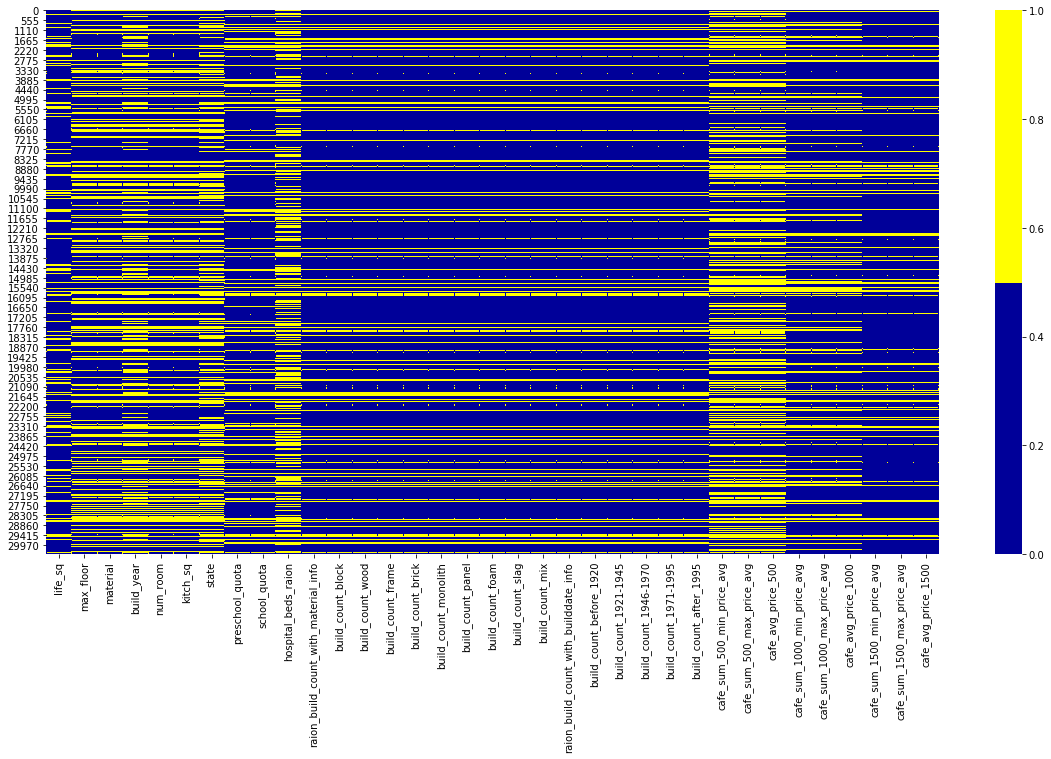

In [19]:
df_fillrates = get_column_fill_rates(df,0.0)
unfilled_cols = df_fillrates[df_fillrates['frac_full']<=0.90]['column_name'].tolist()

plt.figure(figsize=[20,10])
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(df[unfilled_cols].isnull().sample(frac=1).reset_index(drop=True), cmap=sns.color_palette(colours))

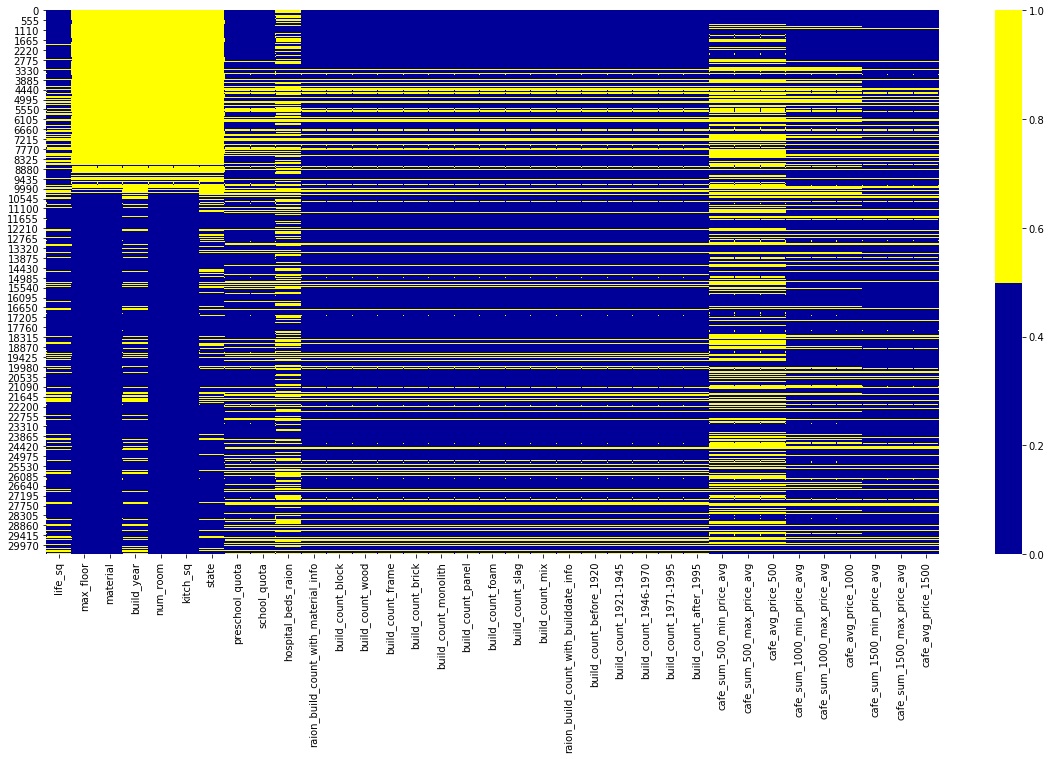

In [20]:
plt.figure(figsize=[20,10])
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(df[unfilled_cols].isnull().reset_index(drop=True), cmap=sns.color_palette(colours))

##### Check the fill rate of the features

Keep all features having more than 90% (arbitrary) of their values

In [21]:
threshold = 0.90
df_fillrates = get_column_fill_rates(df,threshold)
display(df_fillrates.sort_values("frac_full", ascending=True)[:10])

,column_name,frac_full
229,cafe_sum_2000_min_price_avg,0.943389
230,cafe_sum_2000_max_price_avg,0.943389
231,cafe_avg_price_2000,0.943389
252,cafe_sum_3000_min_price_avg,0.967477
254,cafe_avg_price_3000,0.967477
253,cafe_sum_3000_max_price_avg,0.967477
275,cafe_sum_5000_min_price_avg,0.990253
276,cafe_sum_5000_max_price_avg,0.990253
277,cafe_avg_price_5000,0.990253
269,prom_part_5000,0.994158


In [22]:
filled_cols = df_fillrates.column_name.tolist()
print(f'Number of features more than {round(100*threshold)}% filled: { len(filled_cols)}')

Number of features more than 90% filled: 256


##### Check the fill rate of the rows

**Note** this is passive; nothing is done with this info; it will also change when the unfilled features are removed

<font color='red' size=2>
    If this were applied, then the target_feature would need to be included (or matched by keeping the `id`)
</font>

In [23]:
threshold = 0.85
df_fillrates = get_row_fill_rates(df,threshold)
display(df_fillrates.sort_values("frac_full", ascending=True)[:10])

,id,row_counts,frac_full
3589,3589,248,0.852234
20231,20231,250,0.859107
5094,5094,250,0.859107
8474,8474,250,0.859107
7972,7972,250,0.859107
7172,7172,250,0.859107
7902,7902,250,0.859107
22097,22097,250,0.859107
5105,5105,250,0.859107
5277,5277,250,0.859107


In [24]:
print(f'Number of features more than {round(100*threshold)}% filled: { df_fillrates.shape[0]}')

Number of features more than 85% filled: 30470


##### Check the information content of the features

If the features contain little useful information (_ie_ they have low variance), they might not contribute much to the model. 
<br/>
For efficiecy reasons, it might be best to drop these, though the resulting model will likely be unchanged.

In [25]:
num_rows = len(df.index)
low_information_cols = [] #

for col in df.columns:
    cnts = df[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.95:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

oil_chemistry_raion: 99.02858%
no     30175
yes      296
Name: oil_chemistry_raion, dtype: int64

railroad_terminal_raion: 96.27187%
no     29335
yes     1136
Name: railroad_terminal_raion, dtype: int64

nuclear_reactor_raion: 97.16780%
no     29608
yes      863
Name: nuclear_reactor_raion, dtype: int64

big_road1_1line: 97.43691%
no     29690
yes      781
Name: big_road1_1line, dtype: int64

railroad_1line: 97.06934%
no     29578
yes      893
Name: railroad_1line, dtype: int64

cafe_count_500_price_high: 97.25641%
0    29635
1      787
2       38
3       11
Name: cafe_count_500_price_high, dtype: int64

mosque_count_500: 99.51101%
0    30322
1      149
Name: mosque_count_500, dtype: int64

cafe_count_1000_price_high: 95.52689%
0    29108
1     1104
2      145
3       51
4       39
5       15
6        8
7        1
Name: cafe_count_1000_price_high, dtype: int64

mosque_count_1000: 98.08342%
0    29887
1      584
Name: mosque_count_1000, dtype: int64

mosque_count_1500: 96.21936%
0    29

In [26]:
len(low_information_cols)

10

##### Dropping rows of cat. features with low representation

Consider dropping rows which contribute to the tail-end of features' distributions

(_Ideally, they would be outliers in several features, but this is difficult to check with no promise of a significant reward_)

In [27]:
num_rows = len(df.index)
low_rep_cat_cols = [] #

col = 'sub_area'
cnts = df[col].value_counts(dropna=False)
top_pct = (cnts/num_rows).iloc[0]

low_rep_cat_cols.append(col)
print('{0}: {1:.5f}%'.format(col, top_pct*100))
df_cnts = cnts.reset_index().rename(columns={'index':'sub_area', 'sub_area':'counts'})

sub_area: 5.82849%


In [28]:
df_cnts['%'] = df_cnts.counts.apply(lambda x: round(100.*x/num_rows,2))
df_cnts = df_cnts.sort_values('counts',ascending=False)

In [29]:
df_cnts.head(20)

,sub_area,counts,%
0,Poselenie Sosenskoe,1776,5.83
1,Nekrasovka,1611,5.29
2,Poselenie Vnukovskoe,1372,4.50
3,Poselenie Moskovskij,925,3.04
4,Poselenie Voskresenskoe,713,2.34
5,Mitino,679,2.23
6,Tverskoe,678,2.23
7,Krjukovo,518,1.70
8,Mar'ino,508,1.67
9,Poselenie Filimonkovskoe,496,1.63


In [30]:
csum = np.cumsum(df_cnts['%'].values)

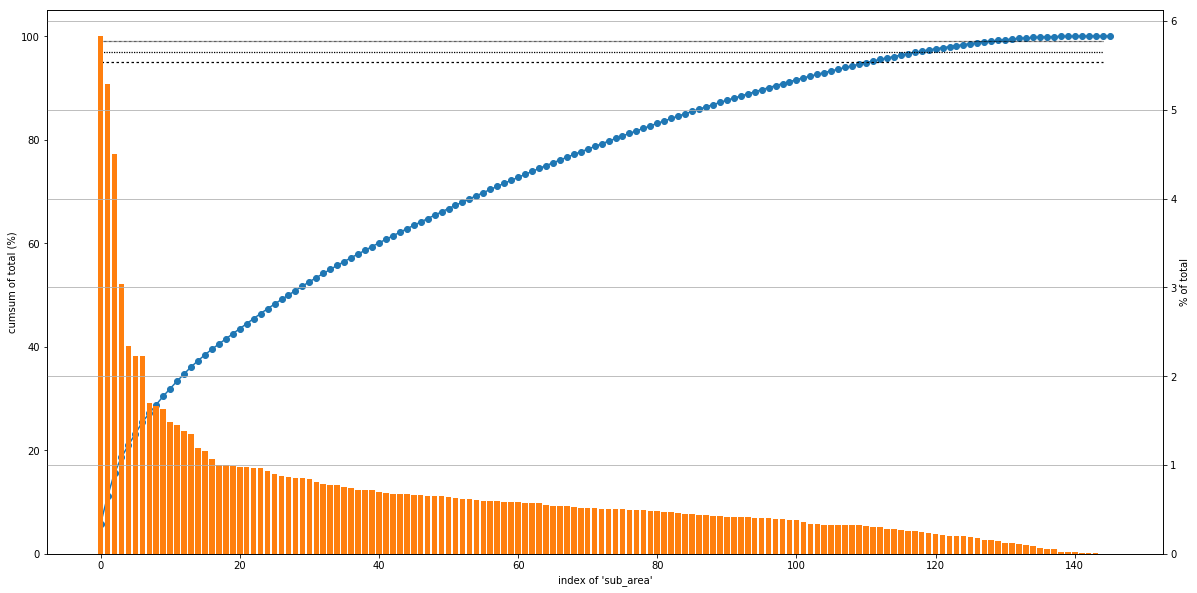

In [31]:
fig, ax = plt.subplots(1,1,figsize=[20,10])
ax.plot(csum,'o-')
ax.plot([0,144],[99,99],'k--', dashes=[0.5,0.5], linewidth=1.25)
ax.plot([0,144],[97,97],'k--', dashes=[1.0,1.0], linewidth=1.25)
ax.plot([0,144],[95,95],'k--', dashes=[2.0,2.0], linewidth=1.25)
ax.set_ylabel('cumsum of total (%)')
ax.set_ylim(0,105)
ax1=ax.twinx()
ax1.bar(x=df_cnts.index, height=df_cnts['%'].values, color='C1')
ax1.set_ylabel('% of total')
ax1.grid()
ax.set_xlabel('index of \'sub_area\'');

In [32]:
cats_to_exclude = []
counts = 0
for n,r in df_cnts.sort_values('counts').iterrows():

    if counts/num_rows > 0.01:
        print(counts, counts/num_rows)
        break
    counts += r['counts']
    cats_to_exclude.append(r['sub_area'])

342 0.011223786551146992


In [33]:
print(len(cats_to_exclude))
print(cats_to_exclude)

18
['Poselenie Klenovskoe', 'Poselenie Mihajlovo-Jarcevskoe', 'Poselenie Kievskij', 'Poselenie Shhapovskoe', 'Molzhaninovskoe', 'Poselenie Marushkinskoe', 'Vostochnoe', 'Poselenie Voronovskoe', 'Arbat', 'Poselenie Mosrentgen', 'Poselenie Kokoshkino', 'Poselenie Krasnopahorskoe', 'Poselenie Rogovskoe', 'Poselenie Rjazanovskoe', "Krasnosel'skoe", 'Severnoe', 'Vnukovo', 'Kapotnja']


In [34]:
df_cnts[df_cnts['sub_area'].isin(cats_to_exclude)]

,sub_area,counts,%
128,Kapotnja,49,0.16
129,Vnukovo,44,0.14
130,Severnoe,37,0.12
131,Krasnosel'skoe,37,0.12
132,Poselenie Rjazanovskoe,34,0.11
133,Poselenie Rogovskoe,31,0.10
134,Poselenie Krasnopahorskoe,27,0.09
135,Poselenie Kokoshkino,20,0.07
136,Poselenie Mosrentgen,19,0.06
137,Arbat,15,0.05


**Notes** 

Strategies:
* drop the rows with these values $\to$ _means no prediction will be made for these!!!_
* combine these values into a new value, e.g. `'other'`
* (advanced) combine nearby regions of low counts into neighbors with higher counts

<font color='red' size=3>
    Warning: as above, if this were applied, then the target_feature would need to be included (or matched by keeping the `id`)
</font>

#### Correlation-based feature drop

In [35]:
from helpers.correlation_feature_drop import get_dropped_columns

In [36]:
threshold = 0.9

In [38]:
# Note: be sure to include the target feature in the correlation --> the current function requires it.
df_corr = df.drop(columns=ignore_cols+string_cols)
df_corr[target_feature] = df_targ['price_doc']
df_corr = df_corr.corr().abs()

In [39]:
drop_corr_cols = get_dropped_columns(df_corr, target_feature, threshold, False)

Index(['col1', 'col2', 'corr'], dtype='object')
Index(['col1', 'col2', 'corr', 'self', 'price_doc'], dtype='object')


#### Select the cols to keep

In [40]:
keep_cols = [c for c in df.columns.tolist() if (c in filled_cols) & (c not in drop_corr_cols + low_information_cols)]

In [41]:
df = df[keep_cols]
print(df.shape) #(30471, 116)
#df = df[df['sub_area'].isin(cats_to_exclude)==False].copy()
print(df.shape)

(30471, 105)
(30471, 105)


### Transformations

#### Inspect the categorical then do encoding

**Note** need to regrab the new set of string cols since some were dropped.

In [42]:
string_cols = df.drop(columns=ignore_cols).select_dtypes('object').columns.tolist()

In [43]:
print(string_cols)

['product_type', 'sub_area', 'culture_objects_top_25', 'thermal_power_plant_raion', 'incineration_raion', 'radiation_raion', 'big_market_raion', 'detention_facility_raion', 'water_1line', 'ecology']


In [44]:
df[string_cols].head()

,product_type,sub_area,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,radiation_raion,big_market_raion,detention_facility_raion,water_1line,ecology
0,Investment,Bibirevo,no,no,no,no,no,no,no,good
1,Investment,Nagatinskij Zaton,yes,no,no,no,no,no,no,excellent
2,Investment,Tekstil'shhiki,no,no,no,yes,no,no,no,poor
3,Investment,Mitino,no,no,no,no,no,no,no,good
4,Investment,Basmannoe,no,no,no,yes,no,no,no,excellent


**Note**
* Ordinals:
    * 'ecology'
* OneHots
    * 'sub_area', 'product_type' (but only two vals)
* Binaries
    * the rest
    * _But these will also be considered ordinals_

~~<font color='red' size=3>
    EDIT: dropped 'sub_area' functionality
</font>~~

In [45]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer

import categorical_encoding
from categorical_encoding import OrdinalEncoderNans


onehot_cat_cols = ["sub_area", "product_type"]
#onehot_cat_cols = ["product_type"]

ord4_cat_cols = ["ecology"]
ord4_cats = ['poor', 'satisfactory', 'good', 'excellent', 'no data'] # Normally, this is a nested list, ie [[1,2,3,...]]

ord2_cat_cols = [e for e in string_cols if (e not in onehot_cat_cols) & (e not in ord4_cat_cols) ]
ord2_cats = len(ord2_cat_cols)*[["no", "yes"]]

In [46]:
df[onehot_cat_cols].nunique()

sub_area        146
product_type      2
dtype: int64

In [47]:
onehot_sum = sum(df[onehot_cat_cols].nunique())

print(len(num_cols), len(onehot_cat_cols), len(ord2_cat_cols), len(ord4_cat_cols))
sum([len(num_cols), onehot_sum, len(ord2_cat_cols), len(ord4_cat_cols)])

274 2 7 1


430

#### Pipelines

##### Numerical features in a pipeline

**Note** could also use with the ColumnTransformer, like the cat. features, since is only one transform on the subset

In [48]:
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])
# Use in ColumnTransformer as 
#   ("num_pipe",  num_pipeline, num_cols),


##### putting the cat-encs together into the pipeline

In [49]:
# Need to re-grab the numerics as well!
num_cols = df.drop(columns=ignore_cols).select_dtypes(['int', 'float']).columns.tolist()

In [50]:
pipeline_stage1 = ColumnTransformer([    
        ("ignored",   FunctionTransformer(lambda x: x), ignore_cols),
        #("target",  StandardScaler(), target_col),  
        ("num_cols",  StandardScaler(), num_cols),  
        ("onehots",   OneHotEncoder(sparse=False), onehot_cat_cols),
        ("ordinals2", OrdinalEncoder(ord2_cats), ord2_cat_cols),   
        ("ordinals4", OrdinalEncoderNans(ord4_cats), ord4_cat_cols),    
    ])

data = pipeline_stage1.fit_transform(df)

In [51]:
data.shape

(30471, 251)

In [52]:
df.shape

(30471, 105)

####  Retrieve the column names

This is a bit specific here, but generalizable

In [53]:
def get_transformed_column_names(pipeline_transformers):

    prepro_columns = []
    for line in pipeline_stage1.transformers_[:]:

        #print(type(line[1]).__name__ )
        if type(line[1]).__name__ == 'OneHotEncoder':
            # Note: can include old column identifiers in the OHE feature names
            #    with .get_feature_names(ohe_column_names)
            new_cols = line[1].get_feature_names().tolist()
            #print(line[0],'\t', len(new_cols))
            prepro_columns += new_cols
        else:
            new_cols = line[2]
            #print(line[0],'\t', len(new_cols))
            prepro_columns += new_cols    
            
    return prepro_columns

In [54]:
prepro_columns = get_transformed_column_names(pipeline_stage1.transformers_)

In [55]:
onehot_sum = sum(df[onehot_cat_cols].nunique())
check_col_lengths = [len(ignore_cols), len(target_col), len(num_cols), onehot_sum, len(ord2_cat_cols), len(ord4_cat_cols)]
print(*check_col_lengths)
print(sum(check_col_lengths), '==', len(prepro_columns))

2 1 93 148 7 1
252 == 251


#### Rebuild the DF and re-cast the data type

Prepare for the next pipeline: imputing

##### Rebuild the DF

In [56]:
df = pd.DataFrame(data=data, columns=prepro_columns)

##### Re-cast the data types

In [57]:
ignored_dtypes = [df_dtype_dict[c] for c in ignore_cols]

def set_dtypes(prepro_columns, nonfloat_dtypes):
    """Set a new dtype dict for the preprocessed df
    
    Args:
      prepro_columns ([str]): columns for the dict keys
      nonfloat_dtypes ([str]): datatypes for the non-float datatypes 
                               (assumes these are in the front of prepro_columns)

    Returns:
      dict: dictionary of column to datatype
    """

    nr_float_cols = len(prepro_columns)-len(nonfloat_dtypes)

    #### NOTE: all preprocess cols will now be floats
    dtypes_list = nonfloat_dtypes + (nr_float_cols)*['float']

    return dict(zip(prepro_columns, dtypes_list))    

In [58]:
dtypes_dict = set_dtypes(prepro_columns, ignored_dtypes)

In [59]:
len(dtypes_dict)

251

In [60]:
df = df.astype(dtypes_dict)

In [61]:
df.head()

,id,timestamp,full_sq,floor,area_m,green_zone_part,indust_part,school_education_centers_raion,school_education_centers_top_20_raion,healthcare_centers_raion,...,x1_Investment,x1_OwnerOccupier,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,radiation_raion,big_market_raion,detention_facility_raion,water_1line,ecology
0,1,2011-08-20,-0.294873,-0.690013,-0.544788,-0.166746,-1.000975,0.085621,-0.329044,-0.214951,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,2,2011-08-23,-0.531523,-0.877987,-0.390702,0.877732,-0.583340,0.956436,-0.329044,-0.214951,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2,3,2011-08-27,-0.294873,-1.065960,-0.622239,-0.607483,-0.002814,0.666164,-0.329044,-0.214951,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4,2011-09-01,0.914671,0.249854,-0.245700,-0.138328,-0.413849,1.536979,-0.329044,-0.214951,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,5,2011-09-05,0.599138,-0.690013,-0.448374,-1.163354,-0.687151,1.246708,-0.329044,1.794590,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0


## Second stage preprocessing

### Imputing

<font color='green' size=2> 
    Can this be organized with the above into a single pipeline?
    <br/>
    Possibly, since the following stage is an imputer
</font>

In [62]:
from sklearn.impute import SimpleImputer, KNNImputer

**Note** `KNNImputer` failed with a kernel restart. Memory? $\to$ try again

In [63]:
subprepro_columns = [c for c in prepro_columns if c not in ignore_cols + target_col]

In [64]:
pipeline_stage2 = ColumnTransformer([
        ("ignored",   FunctionTransformer(lambda x: x), ignore_cols),
        ('imputer', SimpleImputer(strategy='median'), subprepro_columns),    
    ])
 
####NOTE: still need to Scale the ordinalTransformed feature
data = pipeline_stage2.fit_transform(df)

### Rebuild the DF and re-cast the data type

In [65]:
#### NOTE: can use the same cols and dtypes as before since no further reordering of columns was made
df = pd.DataFrame(data=data, columns=prepro_columns).astype(dtypes_dict)

In [66]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Data columns (total 251 columns):
id                                       30471 non-null int64
timestamp                                30471 non-null datetime64[ns]
full_sq                                  30471 non-null float64
floor                                    30471 non-null float64
area_m                                   30471 non-null float64
green_zone_part                          30471 non-null float64
indust_part                              30471 non-null float64
school_education_centers_raion           30471 non-null float64
school_education_centers_top_20_raion    30471 non-null float64
healthcare_centers_raion                 30471 non-null float64
university_top_20_raion                  30471 non-null float64
sport_objects_raion                      30471 non-null float64
additional_education_raion               30471 non-null float64
shopping_centers_raion                   30471 non-nu

<hr style="border: solid rgb(0,0,0) 0.0px; background-color: rgb(0,0,0);height: 2.0px;"/>

<font color='black' size=5>
    Modeling
</font>

In [68]:
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import model_selection, preprocessing

from sklearn.linear_model import LinearRegression

In [69]:
stasca = StandardScaler()

In [70]:
df_targ['price_doc_'] = stasca.fit_transform(df_targ['price_doc'].values.reshape(-1, 1))

In [71]:
df_targ.head()

,id,price_doc,price_doc_
0,1,5850000,-0.266324
1,2,6000000,-0.234943
2,3,5700000,-0.297704
3,4,13100000,1.250402
4,5,16331452,1.926434


In [72]:
id_list = get_peak_ids(df_targ)

In [75]:
df_targ.id.dtypes

dtype('int64')

In [76]:
id_list = list(map(int, id_list))

In [79]:
df_targ = df_targ[df_targ['id'].isin(id_list)].copy()
#df_idtarg['price_doc'] = stasca.fit_transform(df_idtarg['price_doc'].values.reshape(-1, 1))

In [81]:
df_targ.shape

(26238, 3)

In [82]:
df_targ.head()

,id,price_doc,price_doc_
0,1,5850000,-0.266324
1,2,6000000,-0.234943
2,3,5700000,-0.297704
3,4,13100000,1.250402
4,5,16331452,1.926434


In [83]:
df[df['id'].isin(id_list)].shape

(26238, 251)

In [87]:
'''train, test, y_train, y_test = train_test_split(df.drop(["id", "timestamp"], axis=1), 
                                                df_targ, random_state=10, test_size=0.25)
'''
train, test, y_train, y_test = train_test_split(df[df['id'].isin(id_list)].drop(["id", "timestamp"], axis=1), 
                                                df_targ.drop(["id","price_doc"], axis=1), random_state=10, test_size=0.25)

In [88]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 10,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    #'objective': 'reg:linear',
    # 'objective':'reg:squarederror', 'n_jobs':-1, #for the feature importance
    'eval_metric': 'rmse',
    'silent': 1
}

model = xgb.XGBRegressor(**xgb_params)
model.fit(train,y_train)
predictions = model.predict(test)

## Evaluation

### Errors

In [90]:
y_test.price_doc_.min(), predictions.min()

(-1.4270492341707273, -1.0465661)

In [91]:
# Need an offset since 
#   Mean Squared Logarithmic Error cannot be used when targets contain negative values.
offset = abs(min(y_test.price_doc_.min(), predictions.min()))
print(offset)
rmsle = np.sqrt(metrics.mean_squared_log_error(y_test+offset, predictions+offset))
print("RMSLE: %f" % (rmsle))

1.4270492341707273
RMSLE: 0.154526


Before 14.05.2020
```
1.4720281209972588
RMSLE: 0.218097
```

14.05.2020
```
1.4357715590882796
RMSLE: 0.217262
```

19.05.2020, dropped the 'sub_area' feature
```
1.4357715590882796
RMSLE: 0.218165
```

19.05.2020, dropped rows with distribution spikes
```
1.4270492341707273
RMSLE: 0.154526
```

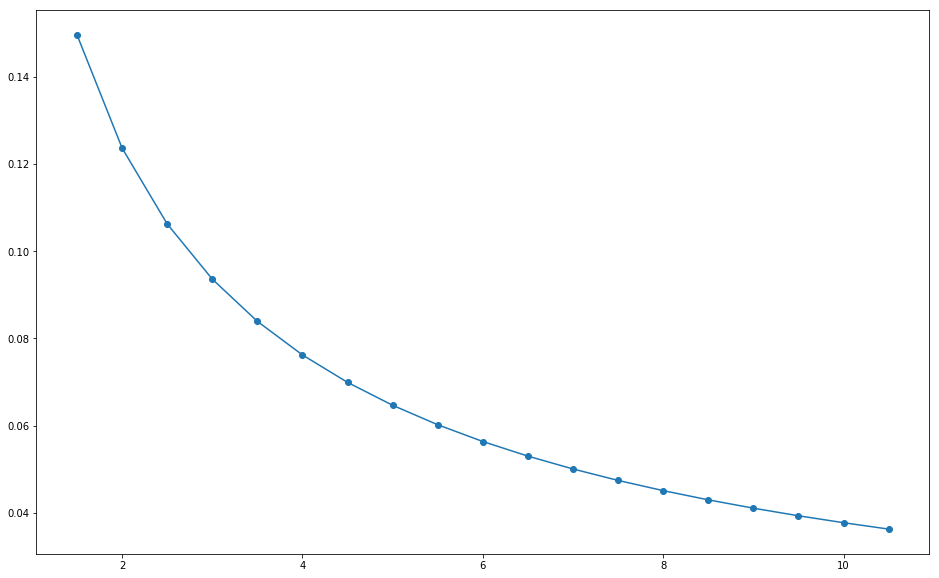

In [92]:
offsets = np.arange(1.5,11.0, 0.5)
errors = []
for x in offsets:
    rmsle = np.sqrt(metrics.mean_squared_log_error(y_test+x, predictions+x))
    errors.append(rmsle)
errors = np.array(errors)

plt.figure(figsize=[16,10])
plt.plot(offsets, errors, 'o-')

### Distributions

In [93]:
predictions

array([-0.52425504, -0.30524182, -0.26566297, ...,  0.02113199,
        0.08848396, -0.21126199], dtype=float32)

In [94]:
bin_width = 0.1
bins=np.arange(-2,12 + bin_width, bin_width)
hist_train, _ = np.histogram(y_train, bins=bins)
hist_test, _ = np.histogram(y_test, bins=bins)
hist_pred, _ = np.histogram(predictions, bins=bins)

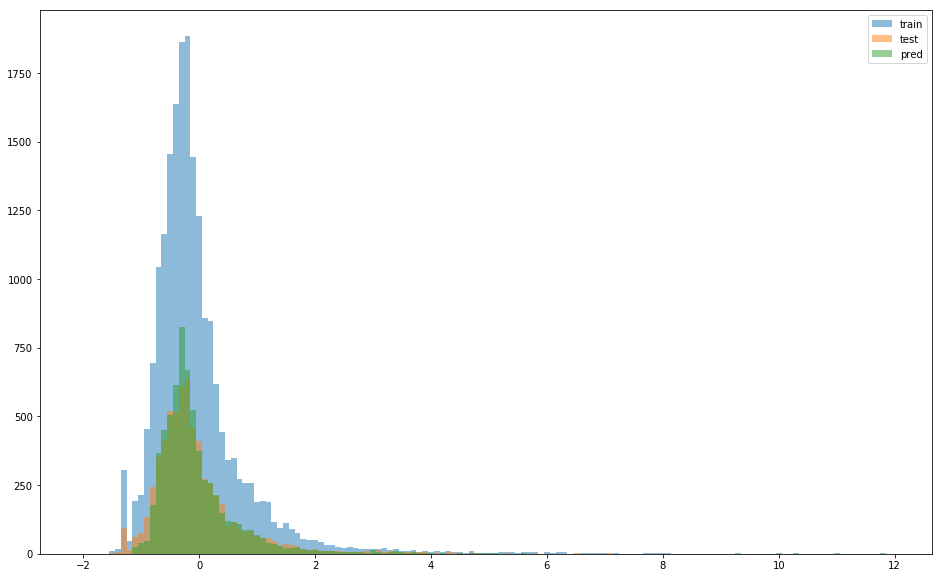

In [95]:
fig, ax = plt.subplots(1,1,figsize=[16,10])

ax.bar( x=bins[:-1],height=hist_train, width=bin_width, label='train', alpha=0.5)
ax.bar( x=bins[:-1],height=hist_test, width=bin_width, label='test', alpha=0.5)
ax.bar( x=bins[:-1],height=hist_pred, width=bin_width, label='pred', alpha=0.5)
ax.legend();

In [96]:
hist_train, _ = np.histogram(y_train, bins=bins, density=True)
hist_test, _ = np.histogram(y_test, bins=bins, density=True)
hist_pred, _ = np.histogram(predictions, bins=bins, density=True)

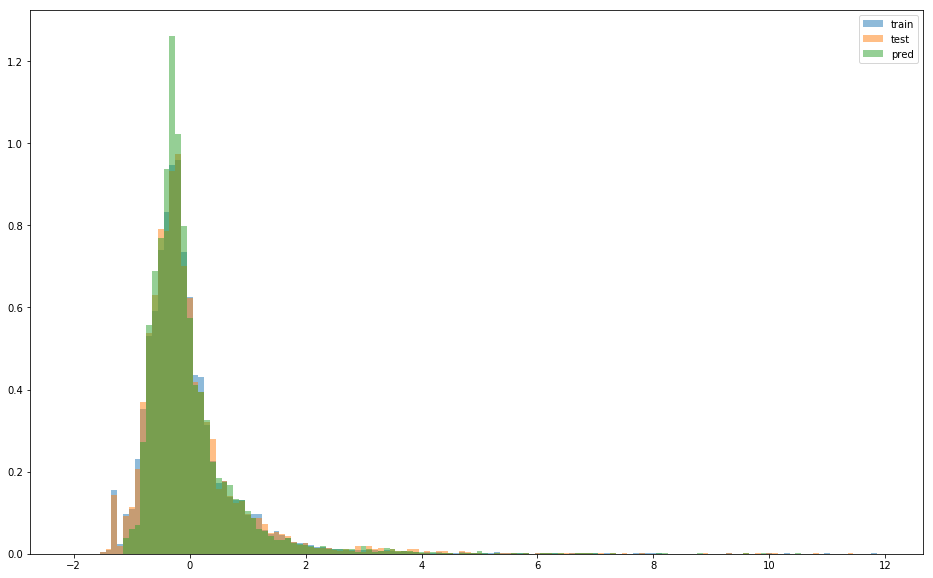

In [97]:
fig, ax = plt.subplots(1,1,figsize=[16,10])

ax.bar( x=bins[:-1],height=hist_train, width=bin_width, label='train', alpha=0.5)
ax.bar( x=bins[:-1],height=hist_test, width=bin_width, label='test', alpha=0.5)
ax.bar( x=bins[:-1],height=hist_pred, width=bin_width, label='pred', alpha=0.5)
ax.legend();

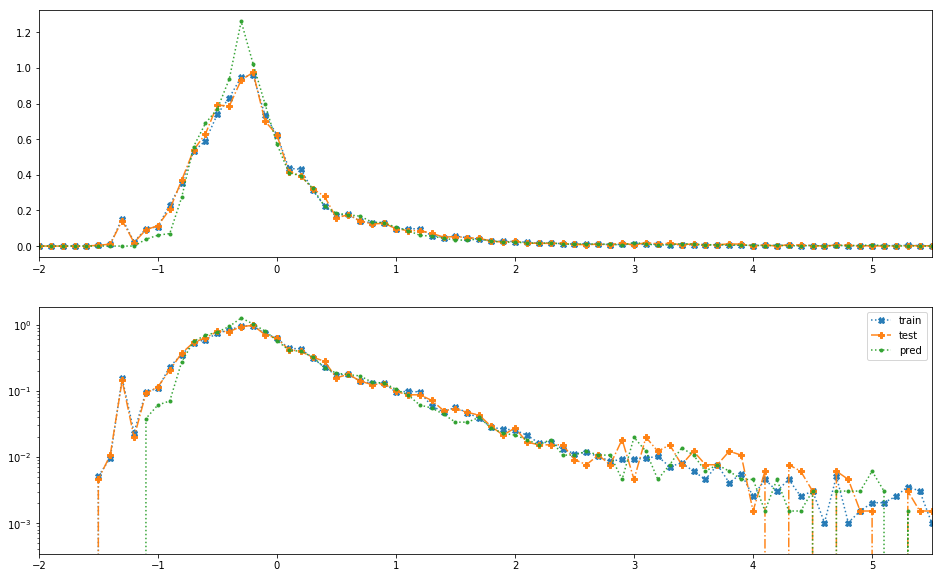

In [98]:
fig, ax = plt.subplots(2,1,figsize=[16,10])

ax =ax.reshape(2)

ax[0].plot( bins[:-1], hist_train, 'X:', label='train', alpha=0.95)
ax[0].plot( bins[:-1], hist_test,  'P-.', label='test',  alpha=0.95)
ax[0].plot( bins[:-1], hist_pred,  '.:', label='pred',  alpha=0.95)
ax[0].set_xlim(-2.0,5.5)

ax[1].plot( bins[:-1], hist_train, 'X:', label='train', alpha=0.95)
ax[1].plot( bins[:-1], hist_test,  'P-.', label='test',  alpha=0.95)
ax[1].plot( bins[:-1], hist_pred,  '.:', label='pred',  alpha=0.95)
ax[1].set_yscale('log')
ax[1].set_xlim(-2.0,5.5)
ax[1].legend();